# Volume 3 Final Notebook

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tqdm import tqdm

from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
from sklearn.model_selection import GridSearchCV, train_test_split

DATA_DIR = './FinalData/'

In [2]:
class WeatherModel():
    def __init__(self, data, model_type='ARIMA'):
        self.data = data
        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

        self.model_type = model_type

    def get_year_data(self):
        data = self.data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, seasonal_order=None):


        if self.residuals is None:
            self.get_residuals()

        arma_models = []

        pbar = tqdm(total=self.residuals.shape[1])

        for i in range(self.residuals.shape[1]):
            pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} {self.model_type} models")
            pbar.update(1)

            if self.model_type == 'ARIMA':
                model = ARIMA(self.residuals[:, i], order=order)
            elif self.model_type == 'SARIMAX':
                if seasonal_order is None:
                    seasonal_order = (1, 0, 1, 365)
                model = SARIMAX(self.residuals[:, i], order=order, seasonal_order=seasonal_order)
            else:
                raise ValueError(f"Invalid model type. Choose 'ARIMA' or 'SARIMAX'. Got {self.model_type}.")
            model_fit = model.fit()
            arma_models.append(model_fit)
            
        self.arma_models = arma_models

        return None

    def fit(self, order):
        self.fit_arma(order)
        return None
    
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]

        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions

In [3]:
class NonlinearLeastSquaresModel():
    def __init__(self, model_type='linear'):
        self.theta = None
        self.shift = None
        self.scale = None
        self.bias = None
        if model_type == 'linear':
            self.func = lambda x, args : args[0] * x
        elif model_type == 'gaussian':
            self.vars = None
            self.func = lambda x, args : args[0] * np.exp(-((x/args[1])**2))

    def fit(self, X, y):

        xs = np.arange(X.shape[1])
        
        shift0 = np.zeros(X.shape[0])
        scale0 = np.ones(X.shape[0])
        bias0 = 0
        if self.func == 'linear':
            theta0 = np.concatenate([shift0, scale0, [bias0]])
        elif self.func == 'gaussian':
            var0 = np.ones(X.shape[0])
            theta0 = np.concatenate([shift0, scale0, var0, [bias0]])

        def f(theta):

            if self.func == 'linear':
                shift = theta[:X.shape[0]]
                scale = theta[X.shape[0]:-1]
                bias = theta[-1]
            elif self.func == 'gaussian':
                shift = theta[:X.shape[0]]
                scale = theta[X.shape[0]:2*X.shape[0]]
                var = theta[2*X.shape[0]:-1]
                bias = theta[-1]
            

            predictions = np.zeros(X.shape[1]) 
            for i in range(X.shape[0]):
                g = CubicSpline(xs, X[i])
                if self.func == 'linear':
                    predictions += self.func(g(xs-shift[i]), scale[i])
                elif self.func == 'gaussian':
                    predictions += self.func(g(xs-shift[i]), [scale[i], var[i]])
            predictions += bias

            return np.mean((predictions - y)**2) + self.lmda * np.sum(np.abs(theta))
        
        res = minimize(f, theta0, method='L-BFGS-B', options={'disp': True})

        self.theta = res.x
        self.shift = self.theta[:X.shape[0]]
        self.scale = self.theta[X.shape[0]:-1]
        self.bias = self.theta[-1]
        return res

    def predict(self, X):
        predictions = np.zeros(X.shape[1])
        xs = np.arange(X.shape[1])
        for i in range(X.shape[0]):
            g = CubicSpline(xs, X[i])
            if self.func == 'linear':
                predictions += self.func(g(xs - self.shift[i]), [self.scale[i]])
            elif self.func == 'gaussian':
                predictions += self.func(g(xs - self.shift[i]), [self.scale[i], self.vars[i]])

        predictions += self.bias
        return predictions

In [4]:
def clean_weather_data(filename, start_year=2003, end_year=2024):
    data = pd.read_csv(filename)
    data = data.replace(999.9, pd.NA)
    data = data.replace(9999.9, pd.NA)
    data['PRCP'] = data['PRCP'].replace(99.99, pd.NA)
    data['DATE'] = pd.to_datetime(data['DATE'])
    data = data[(data['DATE'].dt.year >= start_year) & (data['DATE'].dt.year <= end_year)]
    data = data[~((data['DATE'].dt.month == 2) & (data['DATE'].dt.day == 29))]
    data = data.ffill()
    data = data[["MAX", "MIN", "TEMP", "PRCP", "DEWP", "MXSPD"]]
    return data

In [5]:
ph_data = clean_weather_data(DATA_DIR + 'ph_weather.csv', start_year=2004, end_year=2024)

In [6]:
train_int = int((len(ph_data) * .8) // 365 * 365)
test_int = len(ph_data) - train_int

In [7]:
#ph_data[:train_int]

ph_train, ph_test = ph_data[:train_int], ph_data[train_int:]

ph_train

,MAX,MIN,TEMP,PRCP,DEWP,MXSPD
834,90.7,77.4,82.2,0.0,72.1,9.7
835,84.2,69.4,78.8,0.0,73.5,7.8
836,85.1,71.2,79.6,0.0,72.1,7.8
837,87.4,71.6,79.1,0.0,71.9,7.8
838,86.0,72.7,78.3,0.0,71.9,7.8
...,...,...,...,...,...,...
6673,86.0,71.6,78.4,0.0,70.0,5.8
6674,85.6,70.7,77.0,0.0,66.6,7.8
6675,88.5,70.5,77.5,0.0,60.3,9.7
6676,87.8,68.0,77.0,0.0,59.0,9.7


In [8]:
ph_test

,MAX,MIN,TEMP,PRCP,DEWP,MXSPD
6678,88.7,66.9,78.3,0.0,61.9,7.8
6679,88.9,67.6,79.2,0.0,58.8,5.8
6680,86.4,72.0,80.8,0.0,65.7,5.8
6681,87.8,73.8,80.4,0.0,70.2,3.9
6682,87.1,70.3,78.1,0.0,72.2,7.8
...,...,...,...,...,...,...
8405,86.4,75.2,79.9,0.0,73.6,5.8
8406,82.4,72.9,76.1,0.0,68.0,9.7
8407,87.8,70.7,80.5,0.0,67.3,3.9
8408,88.5,74.1,82.5,0.0,72.0,1.9


In [9]:
1730 / 365

4.739726027397261

In [10]:

ph_data = clean_weather_data(DATA_DIR + 'ph_weather.csv', start_year=2004, end_year=2024)
#print(int(.8 * len(ph_data) // 365) * 365)
print(len(ph_data))
#ph_train, ph_test = train_test_split(ph_data, train_size = int(.8 * len(ph_data) // 365) * 365, shuffle=False)
ph_train, ph_test = ph_data[:train_int+1], ph_data[train_int+1:]#train_test_split(ph_data, train_size = .8, shuffle=False)

wm_ph = WeatherModel(ph_train)
wm_ph.fit(order=(1, 0, 1))
predictions = wm_ph.predict(start=0, future=test_int-1)

7570


Fitting 6/6 ARIMA models: 100%|███████████████████| 6/6 [00:01<00:00,  3.39it/s]


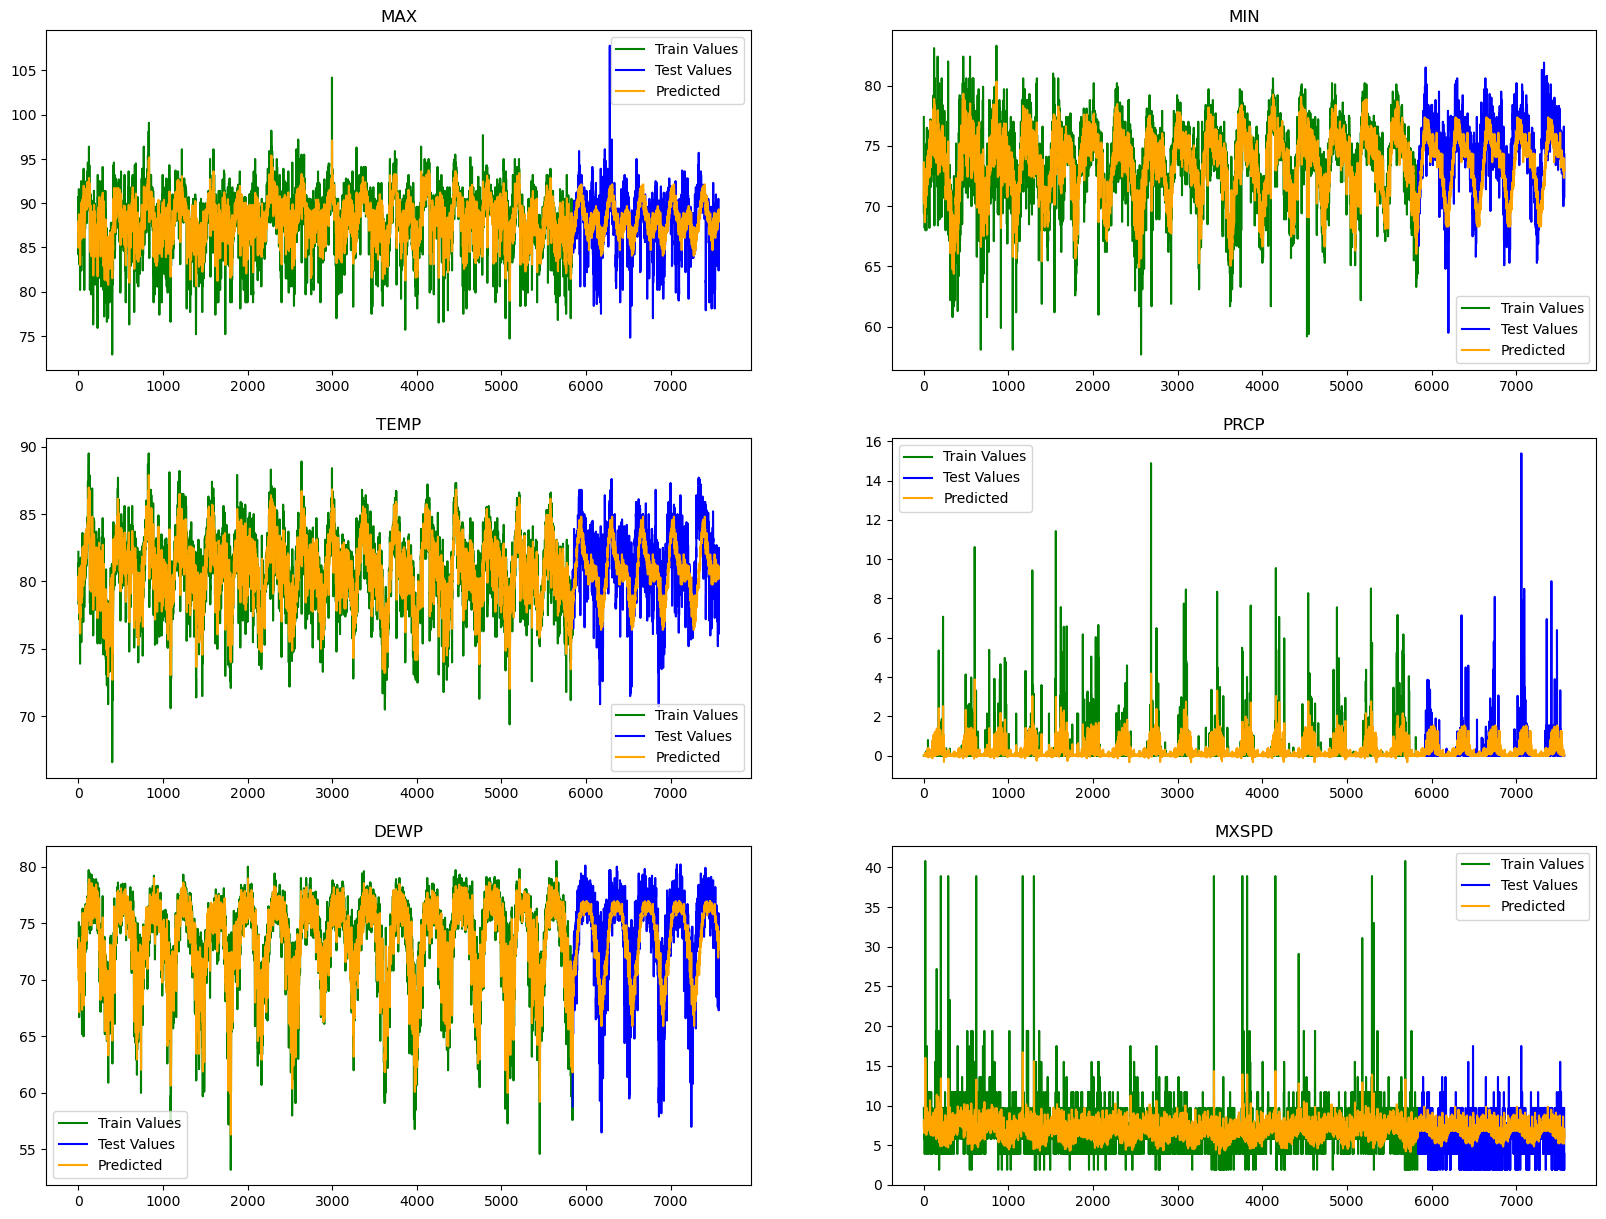

In [11]:


unrolled_data = wm_ph.year_data.reshape(-1, wm_ph.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "PRCP", "DEWP", "MXSPD"]




plt.subplots(3, 2, figsize=(20, 15))
#print(ph_train.shape)
for i in range(len(predictions)):
    train_values = ph_train.values[:, i]
    test_values = ph_test.values[:, i]
    #print(i)
    plt.subplot(3, 2, i + 1)
    plt.title(feature_names[i])
    
    plt.plot(np.arange(len(train_values)), train_values, 'g', label='Train Values')
    plt.plot(np.arange(len(test_values)) + len(train_values), test_values, 'b', label="Test Values")
    plt.plot(predictions[i], c='orange', label='Predicted')
    plt.legend()

# for i in range(len(predictions)):
#     plt.figure(figsize=(20, 5))
#     plt.title(feature_names[i])
#     plt.plot(unrolled_data[i])
#     plt.plot(predictions[i])
#     plt.show()